In [1]:
from nltk.corpus import stopwords
import re
import spacy
import pandas as pd

stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")


city_newsletter_re=re.compile(r'([A-Za-z\s]+)?\/?([A-Z\s]+)?(,?\s[A-za-z]+.+\s)?\(Reuters\)')
html_re=re.compile(r'<[^>]+>|&amp;|&lt;|&gt;|&nbsp;')
links_re=re.compile(r'http[s]?:\/\/\S+')
date_re=re.compile(r'(\b(January|February|March|April|May|June|July|August|September|October|November|December)\b\s\d{1,2},\s\d{4})',re.IGNORECASE)
username_re=re.compile(r'@\w+')
punctuation_re=re.compile(r'[^\w\s]')
image_reference=re.compile(r'(Featured|Photo\sby|Image)[\w\/\s]+',re.IGNORECASE)

def data_lemmatizing(text): 
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc]
)

def preprocess_data_fake_news(text):
    text=date_re.sub('',text)
    text=image_reference.sub('',text)
    text=html_re.sub('',text)
    text=username_re.sub('',text)
    text=links_re.sub('',text)
    text=punctuation_re.sub(' ',text)
    return text

def preprocess_data_true_news(text):
    text=city_newsletter_re.sub('',text, count=1)
    text=links_re.sub('',text)
    text=punctuation_re.sub(' ',text)
    return text

def remove_stopwords(text):
    return " ".join(w for w in text.split() if w.lower() not in stop_words)

def lower_text(text):
    return text.lower()

D:\github\AI-examples\AI_examples\.venv\lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
from tqdm import tqdm

tqdm.pandas()


df_fake= pd.read_csv("data/Fake.csv")
df_true= pd.read_csv("data/True.csv")

df_true.isna().sum()
df_true.drop_duplicates(inplace=True)
df_true.reset_index(drop=True, inplace=True)

df_fake["label"] = 0
df_true["label"] = 1

In [3]:
df_fake['cleaned_text'] = df_fake['text'].progress_apply(preprocess_data_fake_news)
df_fake['clean_text']=df_fake['cleaned_text'].progress_apply(data_lemmatizing)
df_fake['clean_text']=df_fake['clean_text'].progress_apply(remove_stopwords)
df_fake['clean_text_lower']=df_fake['clean_text'].progress_apply(lower_text)

100%|██████████| 23481/23481 [00:00<00:00, 601774.73it/s]


In [4]:
df_true['cleaned_text'] = df_true['text'].progress_apply(preprocess_data_true_news)
df_true['clean_text'] = df_true['cleaned_text'].progress_apply(data_lemmatizing)
df_true['clean_text']=df_true['clean_text'].progress_apply(remove_stopwords)
df_true['clean_text_lower']=df_true['clean_text'].progress_apply(lower_text)

100%|██████████| 21211/21211 [00:00<00:00, 634361.41it/s]


In [5]:
frames=[df_true,df_fake]
df=pd.concat(frames)
df.reset_index(drop=True,inplace=True)
df.drop_duplicates() 
df = df.dropna(subset=["clean_text"]) 
df = df.sample(frac = 1)
df.to_csv("data/fake_and_real_news_final_.csv")

In [6]:
df.sample(3)

,title,text,subject,date,label,cleaned_text,clean_text,clean_text_lower
2634,"Despite recusal, Trump has confidence in Sessi...",WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"July 20, 2017",1,President Donald Trump has confidence in At...,President Donald Trump confidence Attorney Gen...,president donald trump confidence attorney gen...
3722,Controversial Milwaukee County sheriff says ta...,WASHINGTON (Reuters) - Milwaukee County Sherif...,politicsNews,"May 17, 2017",1,Milwaukee County Sheriff David Clarke an A...,Milwaukee County Sheriff David Clarke African ...,milwaukee county sheriff david clarke african ...
35760,HYSTERICAL! HILLARY CLINTON Upstaged By Man Be...,A man with stickers on his face must have been...,politics,"Feb 2, 2016",0,A man with stickers on his face must have been...,man sticker face must pretty hungry last night...,man sticker face must pretty hungry last night...


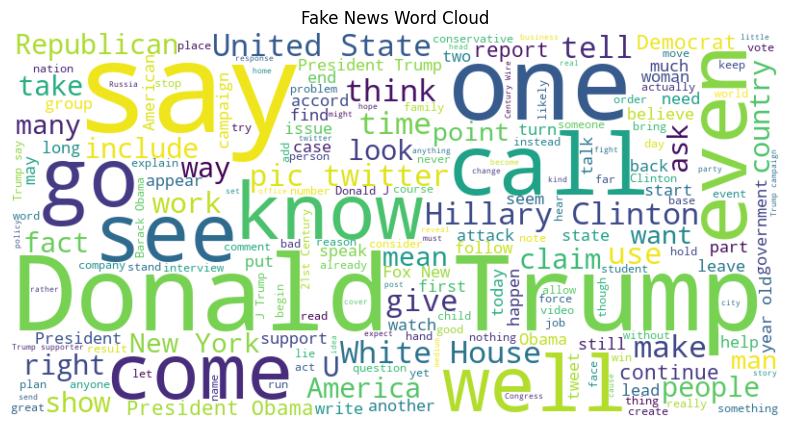

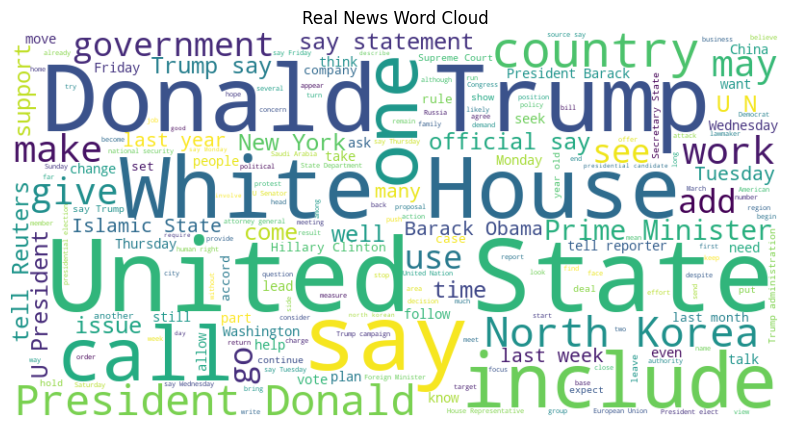

In [7]:
fake_news=df[df['label']==0]
real_news=df[df['label']==1]
text_fake_news = ' '.join(fake_news['clean_text'].astype(str).tolist())
text_real_news = ' '.join(real_news['clean_text'].astype(str).tolist())
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_fake_news)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("./diagrams/wc_fn.png")
plt.title("Fake News Word Cloud")
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_real_news)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Real News Word Cloud")
plt.savefig("./diagrams/wc_rn.png")
plt.show()